## Import modules:

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.preprocessing.image
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import sklearn.linear_model
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import os;
import datetime  
import cv2 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import digitRecognizerNN
from utils import *
%matplotlib inline

#display parent directory and working directory
#print(os.path.dirname(os.getcwd())+':', os.listdir(os.path.dirname(os.getcwd())));
#print(os.getcwd()+':', os.listdir(os.getcwd()));

Using TensorFlow backend.


## Explore the data:

In [2]:
## load and check data -training

dataFiles = {'train': './data/train.csv', 'test': './data/test.csv'}
dataFrame = {}
for key in ['train','test']:
    if os.path.isfile(dataFiles[key]):
        dataFrame[key] = pd.read_csv(dataFiles[key])
        print(key + ' file loaded: data_df({0[0]},{0[1]})'.format(dataFrame[key].shape))
    else:
        print('Error: train.csv not found')
    
    # basic info about data
    print('')
    print(dataFrame[key].info())
    
    # no missing values
    print('')
    print(dataFrame[key].isnull().any().describe())
    
    if 'label' in dataFrame[key].columns:
        # 10 different labels ranging from 0 to 9
        print('')
        print('distinct labels ', np.sort(dataFrame[key]['label'].unique()))
        
        # data are approximately balanced (less often occurs 5, most often 1)
        print('')
        print(dataFrame[key]['label'].value_counts())

    print('')
    print('------------')
    print('')

train file loaded: data_df(42000,785)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None

count       785
unique        1
top       False
freq        785
dtype: object

distinct labels  [0 1 2 3 4 5 6 7 8 9]

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

------------

test file loaded: data_df(28000,784)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB
None

count       784
unique        1
top       False
freq        784
dtype: object

------------



## Build the x (data) and y (labels) vectors for training

x_train_valid.shape =  (42000, 28, 28, 1)
y_train_valid_labels.shape =  (42000,)
y_train_valid.shape =  (42000, 10)
image_size =  784
image_width =  28
image_height =  28
labels_count =  10


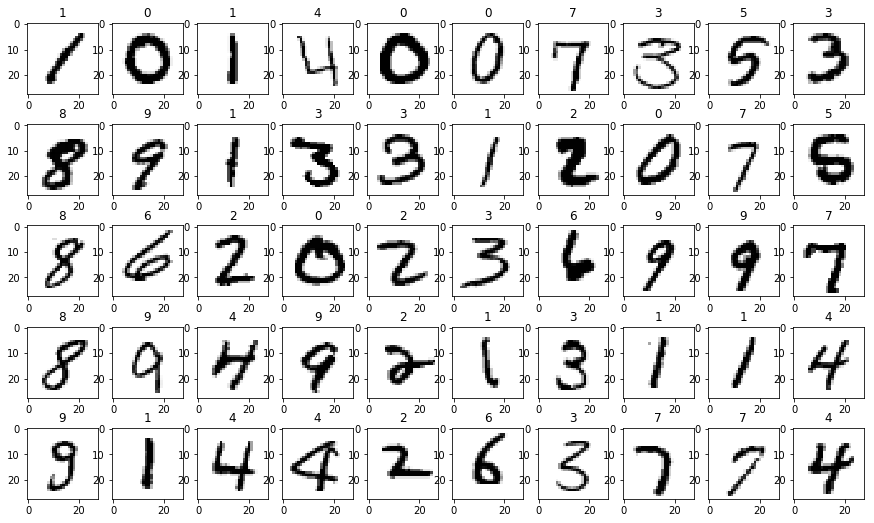

In [3]:
# extract and normalize images
image_size = 784
image_width = image_height = 28
x_train_valid = dataFrame['train'].iloc[:,1:].values.reshape(-1,image_height,image_width,1) # (42000,28,28,1) array
x_train_valid = x_train_valid.astype(np.float) # convert from int64 to float32
x_train_valid = normalize_data(x_train_valid)

# extract image labels
y_train_valid_labels = dataFrame['train'].iloc[:,0].values # (42000,1) array
labels_count = np.unique(y_train_valid_labels).shape[0] # number of different labels = 10

#plot some images and labels
plt.figure(figsize=(15,9))
for i in range(50):
    plt.subplot(5,10,1+i)
    plt.title(y_train_valid_labels[i])
    plt.imshow(x_train_valid[i].reshape(28,28), cmap=cm.binary)
    
# labels in one hot representation
y_train_valid = dense_to_one_hot(y_train_valid_labels, labels_count).astype(np.uint8)


print('x_train_valid.shape = ', x_train_valid.shape)
print('y_train_valid_labels.shape = ', y_train_valid_labels.shape)
print('y_train_valid.shape = ', y_train_valid.shape)
print('image_size = ', image_size )
print('image_width = ', image_width)
print('image_height = ', image_height)
print('labels_count = ', labels_count)

## Data augmentation

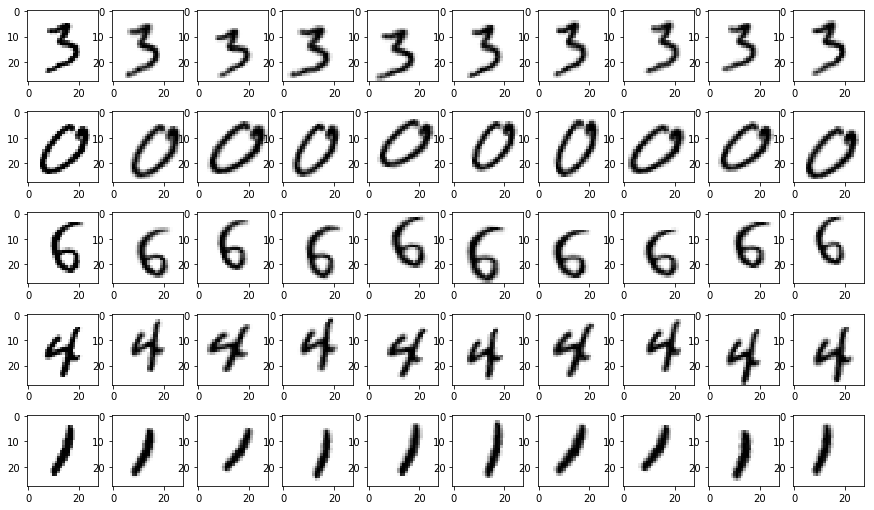

In [4]:
#Test how the image generation is doing...
fig,axs = plt.subplots(5,10, figsize=(15,9))
for i in range(5):
    n = np.random.randint(0,x_train_valid.shape[0]-2)
    axs[i,0].imshow(x_train_valid[n:n+1].reshape(28,28),cmap=cm.binary)
    axs[i,1].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,2].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,3].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,4].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,5].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,6].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,7].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,8].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)
    axs[i,9].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.binary)


## Train Neural Network

In [8]:
## train the neural network graph
from digitRecognizerNN import nn_class
#nn_name = ['nn0','nn1','nn2','nn3','nn4','nn5','nn6','nn7','nn8','nn9']

nn_name = ['myDigitRecognizerNN']

# cross validations
cv_num = 10 # cross validations default = 20 => 5% validation set
kfold = sklearn.model_selection.KFold(cv_num, shuffle=True, random_state=123)


#for i,(train_index, valid_index) in enumerate(kfold.split(x_train_valid)):
#We take only 1k samples, just to test; it takes 20 min in my office computer without gpu
for i,(train_index, valid_index) in enumerate(kfold.split(x_train_valid[0:10000])):
    # start timer
    start = datetime.datetime.now();
    
    # No training... Network was already trained
    #if True:
    #    break;
    
    # train and validation data of original images
    x_train = x_train_valid[train_index]
    y_train = y_train_valid[train_index]
    x_valid = x_train_valid[valid_index]
    y_valid = y_train_valid[valid_index]
    
    # create neural network graph
    nn_graph = nn_class(nn_name = nn_name[i]) # instance of nn_class
    nn_graph.create_graph() # create graph
    nn_graph.attach_saver() # attach saver tensors
    
    # start tensorflow session
    with tf.Session() as sess:
        
        # attach summaries
        nn_graph.attach_summary(sess) 
        
        # variable initialization of the default graph
        sess.run(tf.global_variables_initializer()) 
    
        # training on original data
        nn_graph.train_graph(sess, x_train, y_train, x_valid, y_valid, n_epoch = 1.0)
        
        # training on augmented data
        nn_graph.train_graph(sess, x_train, y_train, x_valid, y_valid, n_epoch = 14.0,
                            train_on_augmented_data = True)

        # save tensors and summaries of model
        nn_graph.save_model(sess)
    
    
    # only one iteration
    if True:
        break;
        

        
    
print('total running time for training: ', datetime.datetime.now() - start)
#On office computer:
#running time for training:  0:18:37.046805
#total running time for training:  0:19:58.916739

num_weights = 361188
num_biases = 684
07-09-2018 19:45:01 : start training
learnrate =  0.001 , n_epoch =  1.0 , mb_size =  50
0.20 epoch: train/val loss = 1.9537/1.9628, train/val acc = 0.5910/0.5730
0.40 epoch: train/val loss = 0.8576/0.9155, train/val acc = 0.7860/0.7560
0.60 epoch: train/val loss = 0.4518/0.5036, train/val acc = 0.8530/0.8220
0.80 epoch: train/val loss = 0.2848/0.2935, train/val acc = 0.9210/0.9130
1.00 epoch: train/val loss = 0.2283/0.2363, train/val acc = 0.9330/0.9230
running time for training:  0:01:19.680455
generate new set of images
generate new set of images
07-09-2018 19:46:22 : start training
learnrate =  0.001 , n_epoch =  14.0 , mb_size =  50
generate new set of images
1.20 epoch: train/val loss = 0.2071/0.2315, train/val acc = 0.9410/0.9430
1.40 epoch: train/val loss = 0.1743/0.2007, train/val acc = 0.9370/0.9410
1.60 epoch: train/val loss = 0.1408/0.1705, train/val acc = 0.9510/0.9460
1.80 epoch: train/val loss = 0.1289/0.1588, train/val acc = 0.9620/

## Loss and Accuracy

/home/juan/Github/TensorFlowExcercises/DigitRecognizer/tmp.meta
INFO:tensorflow:Restoring parameters from tmp
final train/valid loss = 0.0465/0.0428, train/valid accuracy = 0.9840/0.9850


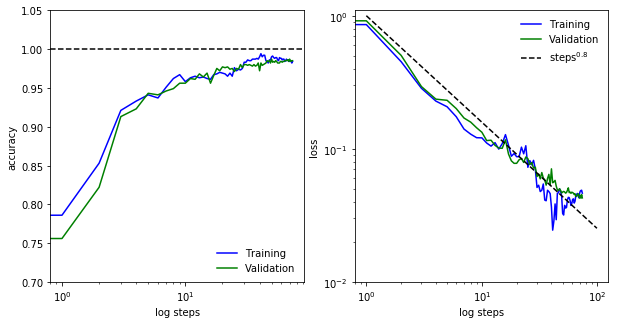

In [41]:
## loss and accuracy curves
train_loss, valid_loss = {}, {}
train_acc, valid_acc = {}, {}

mn = nn_name[0]
nn_graph = nn_class()
sess = nn_graph.load_session_from_file(mn)
train_loss[mn], valid_loss[mn] = nn_graph.get_loss(sess)
train_acc[mn], valid_acc[mn] = nn_graph.get_accuracy(sess)
sess.close()

print('final train/valid loss = %.4f/%.4f, train/valid accuracy = %.4f/%.4f'%(
    train_loss[mn][-1], valid_loss[mn][-1], train_acc[mn][-1], valid_acc[mn][-1]))

plt.figure(figsize=(10, 5));
plt.subplot(1,2,1);
plt.semilogx(np.arange(0,len(train_acc[mn])), train_acc[mn],'-b', label='Training')
plt.semilogx(np.arange(0,len(valid_acc[mn])), valid_acc[mn],'-g', label='Validation')
plt.axhline(1.0,ls='--',c='k')
plt.legend(loc='lower right', frameon=False)
plt.ylim(ymax = 1.05, ymin = 0.7)
plt.ylabel('accuracy')
plt.xlabel('log steps');

plt.subplot(1,2,2)
plt.loglog(np.arange(0,len(train_loss[mn])), train_loss[mn],'-b', label='Training')
plt.loglog(np.arange(0,len(valid_loss[mn])), valid_loss[mn],'-g', label='Validation')
plt.loglog(np.arange(1.0,100), np.asarray([i**(-0.8) for i in range(1,100)]),'--k', label='$\\rm{steps}^{0.8}$')
plt.legend(loc='upper right', frameon=False)
plt.ylim(ymax = 1.1, ymin = 0.01)
plt.ylabel('loss')
plt.xlabel('log steps');

## Visualize the performance - Count misclassified images and show them

tmp
/home/juan/Github/TensorFlowExcercises/DigitRecognizer/tmp.meta
INFO:tensorflow:Restoring parameters from tmp


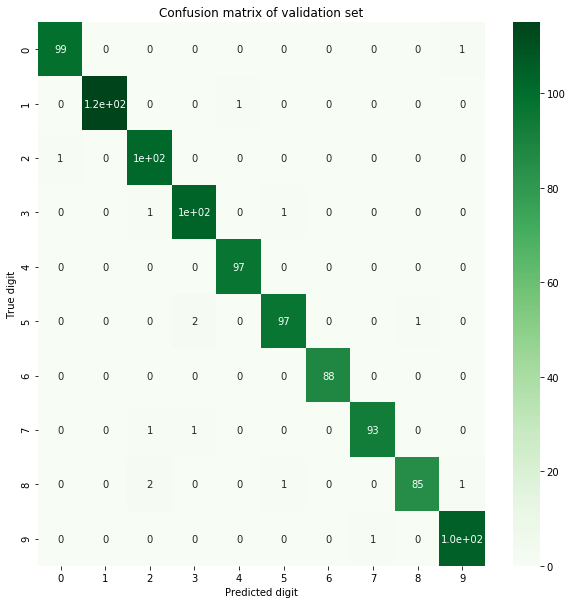

In [9]:
## show confusion matrix
mn = nn_name[0]
print(mn)
nn_graph = nn_class()
sess = nn_graph.load_session_from_file(mn)
y_valid_predicted = nn_graph.forward(sess, x_valid)
sess.close()

cnf_matrix = sklearn.metrics.confusion_matrix(
    one_hot_to_dense(y_valid_predicted), one_hot_to_dense(y_valid)).astype(np.float32)

labels_array = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
fig, ax = plt.subplots(1,figsize=(10,10))
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(labels_array)
ax.set_yticklabels(labels_array)
plt.title('Confusion matrix of validation set')
plt.ylabel('True digit')
plt.xlabel('Predicted digit')
plt.show();

/home/juan/Github/TensorFlowExcercises/DigitRecognizer/tmp.meta
INFO:tensorflow:Restoring parameters from tmp
# false predictions:  15 out of 1000


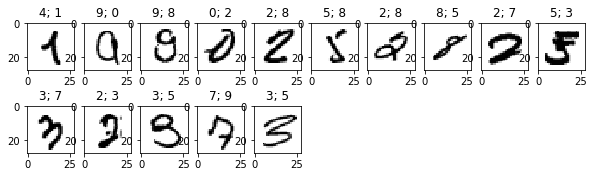

In [47]:
## show misclassified images
y_valid_pred = {}
mn = nn_name[0]
nn_graph = nn_class()
sess = nn_graph.load_session_from_file(mn)
y_valid_pred[mn] = nn_graph.forward(sess, x_valid)
sess.close()

y_valid_pred_label = one_hot_to_dense(y_valid_pred[mn])
y_valid_label = one_hot_to_dense(y_valid)
y_val_false_index = []

for i in range(y_valid_label.shape[0]):
    if y_valid_pred_label[i] != y_valid_label[i]:
        y_val_false_index.append(i)

print('# false predictions: ', len(y_val_false_index),'out of', len(y_valid))

plt.figure(figsize=(15,9))
for j in range(0,5):
    for i in range(0,10):
        if j*10+i<len(y_val_false_index):
            plt.subplot(5,10,j*10+i+1)
            plt.title('{}; {}'.format(y_valid_label[y_val_false_index[j*10+i]],
                               y_valid_pred_label[y_val_false_index[j*10+i]]))
            plt.imshow(x_valid[y_val_false_index[j*10+i]].reshape(28,28),cmap=cm.binary)

## Visualize what is going on inside the neural network

/home/juan/Github/TensorFlowExcercises/DigitRecognizer/tmp.meta
INFO:tensorflow:Restoring parameters from tmp
----------------------- Reshaping layer to plot ------------------------
Original shape: (1, 28, 28, 36)
After reshape: (1, 28, 28, 6, 6)
After transpose: (1, 6, 28, 6, 28)
Before plot: (1, 168, 168)
------------------------------------------------------------------------
h_fc2 =  [[-2.75 -4.91 -2.93  0.93 -5.8   0.26 -1.99 -6.51 11.68  0.55]]


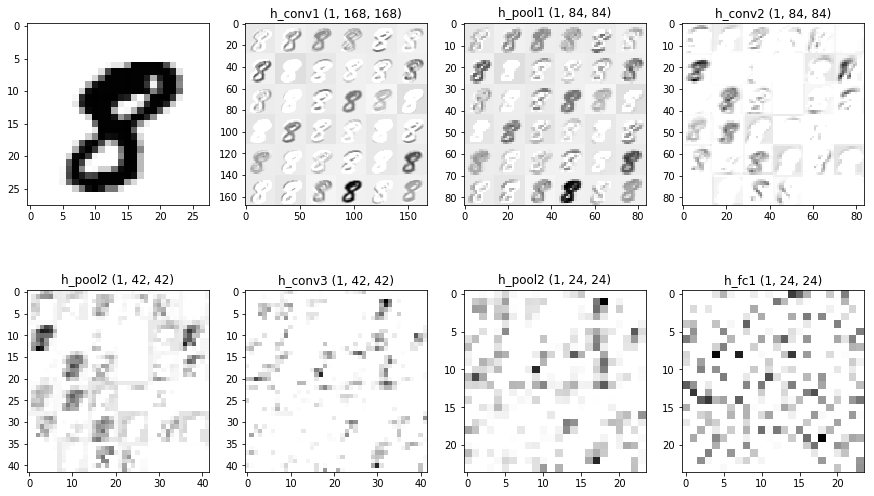

In [57]:
## visualize activations

img_no = 10;
mn = nn_name[0]
nn_graph = nn_class()
sess = nn_graph.load_session_from_file(mn)
(h_conv1, h_pool1, h_conv2, h_pool2,h_conv3, h_pool3, h_fc1,
 h_fc2) = nn_graph.get_activations(sess, x_train_valid[img_no:img_no+1])
sess.close()
    
# original image
plt.figure(figsize=(15,9))
plt.subplot(2,4,1)
plt.imshow(x_train_valid[img_no].reshape(28,28),cmap=cm.binary);

# 1. convolution
print("----------------------- Reshaping layer to plot ------------------------")
#From the nn_class():
#  tunable hyperparameters for nn architecture
#  self.s_f_conv1 = 3;  # filter size of first convolution layer (default = 3)
#  self.n_f_conv1 = 36; # number of features of first convolution layer (default = 36)
#  self.s_f_conv2 = 3;  # filter size of second convolution layer (default = 3)
#  self.n_f_conv2 = 36; # number of features of second convolution layer (default = 36)
#  self.s_f_conv3 = 3;  # filter size of third convolution layer (default = 3)
#  self.n_f_conv3 = 36; # number of features of third convolution layer (default = 36)
#  self.n_n_fc1 = 576;  # number of neurons of first fully connected layer (default = 576)
print("Original shape: {}".format(h_conv1.shape))
h_conv1 = np.reshape(h_conv1,(-1,28,28,6,6))
print("After reshape: {}".format(h_conv1.shape))
h_conv1 = np.transpose(h_conv1,(0,3,1,4,2))
print("After transpose: {}".format(h_conv1.shape))
h_conv1 = np.reshape(h_conv1,(-1,6*28,6*28))
print("Before plot: {}".format(h_conv1.shape))
plt.subplot(2,4,2)
plt.title('h_conv1 ' + str(h_conv1.shape))
plt.imshow(h_conv1[0], cmap=cm.binary);
print("------------------------------------------------------------------------")

# 1. max pooling
h_pool1 = np.reshape(h_pool1,(-1,14,14,6,6))
h_pool1 = np.transpose(h_pool1,(0,3,1,4,2))
h_pool1 = np.reshape(h_pool1,(-1,6*14,6*14))
plt.subplot(2,4,3)
plt.title('h_pool1 ' + str(h_pool1.shape))
plt.imshow(h_pool1[0], cmap=cm.binary);

# 2. convolution
h_conv2 = np.reshape(h_conv2,(-1,14,14,6,6))
h_conv2 = np.transpose(h_conv2,(0,3,1,4,2))
h_conv2 = np.reshape(h_conv2,(-1,6*14,6*14))
plt.subplot(2,4,4)
plt.title('h_conv2 ' + str(h_conv2.shape))
plt.imshow(h_conv2[0], cmap=cm.binary);

# 2. max pooling
h_pool2 = np.reshape(h_pool2,(-1,7,7,6,6))
h_pool2 = np.transpose(h_pool2,(0,3,1,4,2))
h_pool2 = np.reshape(h_pool2,(-1,6*7,6*7))
plt.subplot(2,4,5)
plt.title('h_pool2 ' + str(h_pool2.shape))
plt.imshow(h_pool2[0], cmap=cm.binary);

# 3. convolution
h_conv3 = np.reshape(h_conv3,(-1,7,7,6,6))
h_conv3 = np.transpose(h_conv3,(0,3,1,4,2))
h_conv3 = np.reshape(h_conv3,(-1,6*7,6*7))
plt.subplot(2,4,6)
plt.title('h_conv3 ' + str(h_conv3.shape))

plt.imshow(h_conv3[0], cmap=cm.binary);

# 3. max pooling
h_pool3 = np.reshape(h_pool3,(-1,4,4,6,6))
h_pool3 = np.transpose(h_pool3,(0,3,1,4,2))
h_pool3 = np.reshape(h_pool3,(-1,6*4,6*4))
plt.subplot(2,4,7)
plt.title('h_pool2 ' + str(h_pool3.shape))
plt.imshow(h_pool3[0], cmap=cm.binary);

# 4. FC layer
h_fc1 = np.reshape(h_fc1,(-1,24,24))
plt.subplot(2,4,8)
plt.title('h_fc1 ' + str(h_fc1.shape))
plt.imshow(h_fc1[0], cmap=cm.binary);

# 5. FC layer
np.set_printoptions(precision=2)
print('h_fc2 = ', h_fc2)

/home/juan/Github/TensorFlowExcercises/DigitRecognizer/tmp.meta
INFO:tensorflow:Restoring parameters from tmp
W_conv1: min = -0.3039189 max = 0.28590995 mean = 0.0009036375 std = 0.12076213
W_conv2: min = -0.28827465 max = 0.3149187 mean = -0.0052645453 std = 0.09448863
W_conv3: min = -0.33914068 max = 0.30848268 mean = -0.0068077883 std = 0.09476881


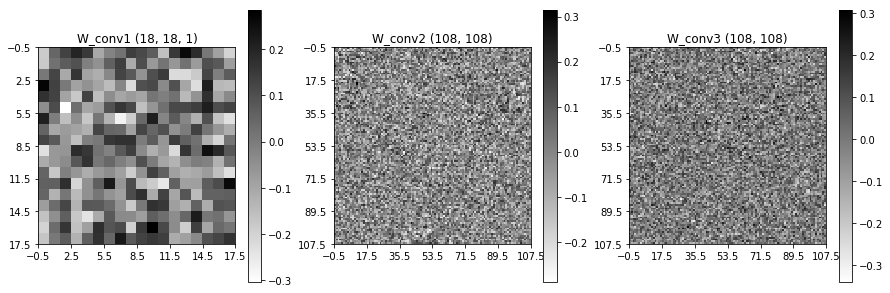

In [60]:
## visualize weights

mn = nn_name[0]
nn_graph = nn_class()
sess = nn_graph.load_session_from_file(mn)
W_conv1, W_conv2, W_conv3, _, _ = nn_graph.get_weights(sess)
sess.close()

print('W_conv1: min = ' + str(np.min(W_conv1)) + ' max = ' + str(np.max(W_conv1))
      + ' mean = ' + str(np.mean(W_conv1)) + ' std = ' + str(np.std(W_conv1)))
print('W_conv2: min = ' + str(np.min(W_conv2)) + ' max = ' + str(np.max(W_conv2))
      + ' mean = ' + str(np.mean(W_conv2)) + ' std = ' + str(np.std(W_conv2)))
print('W_conv3: min = ' + str(np.min(W_conv3)) + ' max = ' + str(np.max(W_conv3))
      + ' mean = ' + str(np.mean(W_conv3)) + ' std = ' + str(np.std(W_conv3)))

#filter sizes of convolution layers:
s_f_conv1 = nn_graph.s_f_conv1
s_f_conv2 = nn_graph.s_f_conv2
s_f_conv3 = nn_graph.s_f_conv3

#From the nn_class():
#  tunable hyperparameters for nn architecture
#  self.s_f_conv1 = 3;  # filter size of first convolution layer (default = 3)
#  self.n_f_conv1 = 36; # number of features of first convolution layer (default = 36)
#  self.s_f_conv2 = 3;  # filter size of second convolution layer (default = 3)
#  self.n_f_conv2 = 36; # number of features of second convolution layer (default = 36)
#  self.s_f_conv3 = 3;  # filter size of third convolution layer (default = 3)
#  self.n_f_conv3 = 36; # number of features of third convolution layer (default = 36)
#  self.n_n_fc1 = 576;  # number of neurons of first fully connected layer (default = 576)

plt.figure(figsize=(15,5))


W_conv1 = np.reshape(W_conv1,(s_f_conv1,s_f_conv1,1,6,6))
W_conv1 = np.transpose(W_conv1,(3,0,4,1,2))
W_conv1 = np.reshape(W_conv1,(s_f_conv1*6,s_f_conv1*6,1))
plt.subplot(1,3,1)
plt.gca().set_xticks(np.arange(-0.5, s_f_conv1*6, s_f_conv1), minor = False);
plt.gca().set_yticks(np.arange(-0.5, s_f_conv1*6, s_f_conv1), minor = False);
plt.grid(which = 'minor', color='b', linestyle='-', linewidth=1)
plt.title('W_conv1 ' + str(W_conv1.shape))
plt.colorbar(plt.imshow(W_conv1[:,:,0], cmap=cm.binary));

W_conv2 = np.reshape(W_conv2,(s_f_conv2,s_f_conv2,6,6,36))
W_conv2 = np.transpose(W_conv2,(2,0,3,1,4))
W_conv2 = np.reshape(W_conv2,(6*s_f_conv2,6*s_f_conv2,6,6))
W_conv2 = np.transpose(W_conv2,(2,0,3,1))
W_conv2 = np.reshape(W_conv2,(6*6*s_f_conv2,6*6*s_f_conv2))
plt.subplot(1,3,2)
plt.gca().set_xticks(np.arange(-0.5, 6*6*s_f_conv2, 6*s_f_conv2), minor = False);
plt.gca().set_yticks(np.arange(-0.5, 6*6*s_f_conv2, 6*s_f_conv2), minor = False);
plt.grid(which = 'minor', color='b', linestyle='-', linewidth=1)
plt.title('W_conv2 ' + str(W_conv2.shape))
plt.colorbar(plt.imshow(W_conv2[:,:], cmap=cm.binary));

W_conv3 = np.reshape(W_conv3,(s_f_conv3,s_f_conv3,6,6,36))
W_conv3 = np.transpose(W_conv3,(2,0,3,1,4))
W_conv3 = np.reshape(W_conv3,(6*s_f_conv3,6*s_f_conv3,6,6))
W_conv3 = np.transpose(W_conv3,(2,0,3,1))
W_conv3 = np.reshape(W_conv3,(6*6*s_f_conv3,6*6*s_f_conv3))
plt.subplot(1,3,3)
plt.gca().set_xticks(np.arange(-0.5, 6*6*s_f_conv3, 6*s_f_conv3), minor = False);
plt.gca().set_yticks(np.arange(-0.5, 6*6*s_f_conv3, 6*s_f_conv3), minor = False);
plt.grid(which = 'minor', color='b', linestyle='-', linewidth=1)
plt.title('W_conv3 ' + str(W_conv3.shape))
plt.colorbar(plt.imshow(W_conv3[:,:], cmap=cm.binary));

## Predict

In [78]:
#Prepare test data and define prediction dictionaries:
x_test = dataFrame['test'].iloc[:,0:].values.reshape(-1,28,28,1) # (28000,28,28,1) array
x_test = x_test.astype(np.float) # convert from int64 to float32
x_test = normalize_data(x_test)
print('x_test.shape = ', x_test.shape)
y_test_pred = {}
y_test_pred_labels = {}

#Start a session with the already trained network:
mn = nn_name[0]
nn_graph = nn_class()
sess = nn_graph.load_session_from_file(mn)

#Make the predictions and dismiss the session:
y_test_pred[mn] = nn_graph.forward(sess, x_test)
sess.close()

#Convert from one hot predictions to labels:
y_test_pred_labels[mn] = one_hot_to_dense(y_test_pred[mn])

#Check that everything is ok...
unique, counts = np.unique(y_test_pred_labels[mn], return_counts=True)
print(mn+': y_test_pred[mn].shape = ', y_test_pred[mn].shape)
print(mn+': y_test_pred_labels[mn].shape = ', y_test_pred_labels[mn].shape)
print(dict(zip(unique, counts)))

x_test.shape =  (28000, 28, 28, 1)
/home/juan/Github/TensorFlowExcercises/DigitRecognizer/tmp.meta
INFO:tensorflow:Restoring parameters from tmp
tmp: y_test_pred[mn].shape =  (28000, 10)
tmp: y_test_pred_labels[mn].shape =  (28000,)
{0: 2765, 1: 3162, 2: 2820, 3: 2791, 4: 2760, 5: 2518, 6: 2745, 7: 2898, 8: 2735, 9: 2806}


## Check predictions by eye

x_test.shape =  (28000, 28, 28, 1)
y_predicted_labels.shape =  (28000,)


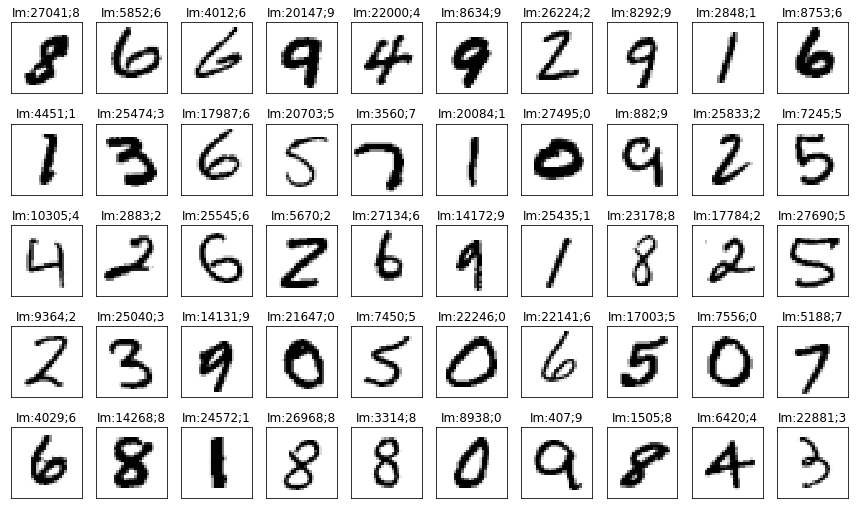

In [79]:
image_width = image_height = 28

# extract image labels
y_predicted_labels = y_test_pred_labels[mn] # (42000,1) array

#plot some images and labels
plt.figure(figsize=(15,9))
for i in range(50):
    n = np.random.randint(0,x_test.shape[0])
    plt.subplot(5,10,1+i)
    plt.title("Im:" + str(n+1) + ";" + str(y_predicted_labels[n]))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[n].reshape(image_height,image_width), cmap=cm.binary)
    
print('x_test.shape = ', x_test.shape)
print('y_predicted_labels.shape = ', y_predicted_labels.shape)

## Prepare submission file

In [80]:
# save predictions
filename = "./tensorflowNeuralNetworkPredictions.csv"
np.savetxt(filename, 
           np.c_[range(1,len(x_test)+1), y_test_pred_labels[mn]], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')

print(filename+' completed')

./tensorflowNeuralNetworkPredictions.csv completed
